In [1]:
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn import datasets
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Problem Generation
Here we generate the data of "Artifical Problem 1" as mentioned in *'Search bias
in ant colony optimization: On the role of competition-balanced systems'* by Blum, Christian and Marco Dorigo.

In [2]:
def assign_class(x, y):
    if (x >= 0.7 or y <= 0.3) and (y >= -0.2 - x):
        return 1
    return 0 

def generate_problem(n_data=400):
    x = []
    y = []
    for i in range(n_data):
        x.append(np.random.uniform(-1,1))
        y.append(np.random.uniform(-1,1))
    labels = []
    for loc_x, loc_y in zip(x,y):
        labels.append(assign_class(loc_x, loc_y))
    return x, y, labels
        
x, y, labels = generate_problem(400)

art_df = pd.DataFrame(list(zip(x, y, labels)), columns=["x", "y", "Class"])
art_df

,x,y,Class
0,0.182802,-0.320887,1
1,-0.271808,0.674254,0
2,-0.225569,0.259229,1
3,0.889987,-0.738899,1
4,0.742809,0.515668,1
...,...,...,...
395,-0.677959,0.659721,0
396,0.543052,-0.809900,0
397,0.129731,-0.863560,0
398,-0.255979,0.218308,1


<ipython-input-3-c4dfd83910aa>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_cluster['Centroid_distance'] = current_cluster[['x', 'y']].apply(lambda x: euclid_dist(x, centroid_list), axis=1)


0    261
Name: Class, dtype: int64
Cluster with class = 0  has an avg quantization error of  0.37494579327450345
1    139
Name: Class, dtype: int64
Cluster with class = 1  has an avg quantization error of  0.6328938777055293


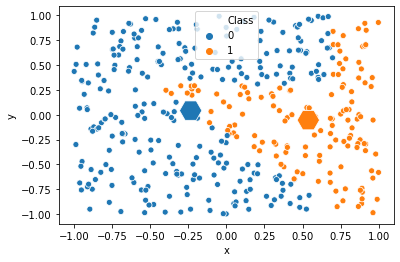

Quantization error =  0.6328938777055293
Davies-bouldin index score 1.627463668535614


In [3]:
def euclid_dist(data, centroid):
    return distance.euclidean(data, centroid)

def show_clustering(df, label="Class", clusters=2, compute_error = True):
    df_centroids = pd.DataFrame([], columns=['x', 'y', 'Centroid'])
    for i in range(clusters):
        current_cluster = df.loc[df[label] == i] 
        mean = current_cluster.mean(axis=0)
        df_centroids = df_centroids.append({'x':mean['x'], 'y':mean['y'], 'Centroid':i}, ignore_index=True)
    df_centroids["Centroid"] = pd.Series(df_centroids['Centroid'], dtype=int)
    
    if compute_error:
        cluster_variances = []
        quantization_error = 0
        for i in range(clusters):
            distances = []
            current_cluster = df.loc[df[label] == i] 
            current_centroid = df_centroids.loc[df_centroids["Centroid"] == i] 
            centroid_list = [current_centroid.loc[i, 'x'], current_centroid.loc[i, 'y']]
    #         print(centroid_list)
            current_cluster['Centroid_distance'] = current_cluster[['x', 'y']].apply(lambda x: euclid_dist(x, centroid_list), axis=1)
            print(current_cluster['Class'].value_counts())

            try:
                cluster_freq=current_cluster['Class'].value_counts().loc[i]
            except KeyError:
                cluster_freq = 0
            cluster_error = (current_cluster['Centroid_distance']/cluster_freq)
    #         print(cluster_error)
            quantization_error += (cluster_error.sum())

            print("Cluster with class =", i, " has an avg quantization error of ", quantization_error/clusters)
    
    # Show clustering
    sns.scatterplot(data=df, x="x", y="y", hue=label)
    sns.scatterplot(data=df_centroids, x="x", y="y", hue="Centroid", marker='H', legend=False, s=500)
    plt.show()
    if compute_error:
        print("Quantization error = ", quantization_error/clusters)
        print("Davies-bouldin index score", sklearn.metrics.davies_bouldin_score(art_df[['x', 'y']], art_df[label]))
show_clustering(art_df, "Class", 2) # For ground truth

0    177
1     17
Name: Class, dtype: int64
Cluster with class = 0  has an avg quantization error of  0.3245007448268153
1    122
0     84
Name: Class, dtype: int64
Cluster with class = 1  has an avg quantization error of  0.8171947547089273


<ipython-input-3-c4dfd83910aa>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_cluster['Centroid_distance'] = current_cluster[['x', 'y']].apply(lambda x: euclid_dist(x, centroid_list), axis=1)


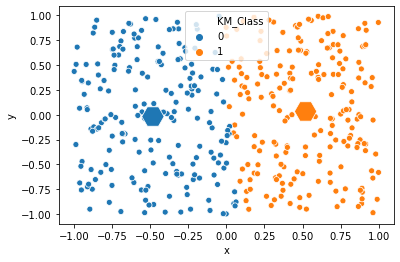

Quantization error =  0.8171947547089273
Davies-bouldin index score 1.1724712787084328


In [4]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(art_df[['x', 'y']])
art_df['KM_Class'] = kmeans.labels_
show_clustering(art_df, label="KM_Class", clusters=2)

In [5]:
def init_particles(min_x=-1, max_x=1, num_clusters=2, num_particles = 3):
    particles = np.random.uniform(min_x, max_x, size=(num_particles, num_clusters, 2))
    return np.array(particles)

def PSO_clustering(df, iterations=10, num_clusters=2, num_particles = 3, omega = 0.5, c1 = 0.5, c2 = 0.5):
#     particles = np.array(init_particles(-1, 1, num_clusters, num_particles))
    particles = [np.array(df[['x', 'y']].sample(num_clusters)) for _ in range(num_particles)]
#     print(particles)
#     df['PSO_Class'] = np.zeros(len(df), dtype = 'int')
#     print(df)
    # Initialize particles which contain N_c randomly selected cluster centroids
    vs = []
    local_best = []
    for it in range(iterations):
        for par_id, par in enumerate(particles): # For each particle do
            fitness = np.zeros(len(par))
            c_len = np.zeros(len(par))
            for idx, (x, y) in enumerate(zip(df.x, df.y)): # For each data vector do 
                distances = [euclid_dist([x,y], centroid) for centroid in par]
                fitness[np.argmin(distances)] += distances[np.argmin(distances)]
                c_len[np.argmin(distances)] += 1
#             print(fitness)
#             fitness[c_len == 0] = 1000
#             c_len[c_len == 0] = 1
            fitness /= c_len+1
#             print(fitness)
            fitness = np.mean(fitness)
#             print("Q-Error: ", fitness)
            
            if (it == 0):
                local_best.append(np.array([par, fitness]))
            elif (fitness < local_best[par_id][1]):
                local_best[par_id] = np.array([par, fitness])
                
        global_best = local_best[np.argmin(np.array(local_best)[:, 1])]
        
        for idx in range(len(particles)):
            if it == 0:
                vs.append((c1*np.random.uniform(0, 1)*(local_best[idx][0]-particles[idx])) + (c2*np.random.uniform(0, 1)*(global_best[0]-particles[idx]))) 
            else:
                vs[idx] = (omega*vs[idx])+(c1*np.random.uniform(0, 1)*(local_best[idx][0]-particles[idx])) + (c2*np.random.uniform(0, 1)*(global_best[0]-particles[idx]))

            particles[idx] = particles[idx] + vs[idx]
            
        print(f"Iteration {it+1}, Best Q-Error: {global_best[1]}", end = '\r')

    return global_best

<ipython-input-5-437092e683ca>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  local_best.append(np.array([par, fitness]))


<ipython-input-5-437092e683ca>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  local_best[par_id] = np.array([par, fitness])


Iteration 30, Best Q-Error: 0.5775887779023153
Best particle centroids:
[[-0.5481121   0.48683217]
 [ 0.15260958 -0.13440338]]


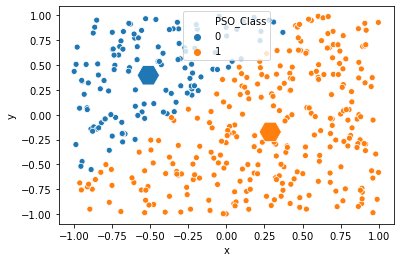

In [6]:
num_clusters = 2
num_particles = 10
iterations = 30

means = PSO_clustering(art_df, iterations, num_clusters, num_particles)[0]
print("\nBest particle centroids:")
print(means)
labels = [np.argmin([euclid_dist([x,y], centroid) for centroid in means]) for (x, y) in zip(art_df.x, art_df.y)]
art_df['PSO_Class'] = labels
show_clustering(art_df, label="PSO_Class", clusters=2, compute_error = False)    

### Iris dataset

            x     y  Class
0    0.202899  0.08      0
1    0.202899  0.08      0
2    0.188406  0.08      0
3    0.217391  0.08      0
4    0.202899  0.08      0
..        ...   ...    ...
145  0.753623  0.92      2
146  0.724638  0.76      2
147  0.753623  0.80      2
148  0.782609  0.92      2
149  0.739130  0.72      2

[150 rows x 3 columns]
0    50
Name: Class, dtype: int64
Cluster with class = 0  has an avg quantization error of  0.01366017403188923
1    50
Name: Class, dtype: int64
Cluster with class = 1  has an avg quantization error of  0.042933515735015144
2    50
Name: Class, dtype: int64
Cluster with class = 2  has an avg quantization error of  0.08395154916225744


<ipython-input-3-c4dfd83910aa>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_cluster['Centroid_distance'] = current_cluster[['x', 'y']].apply(lambda x: euclid_dist(x, centroid_list), axis=1)


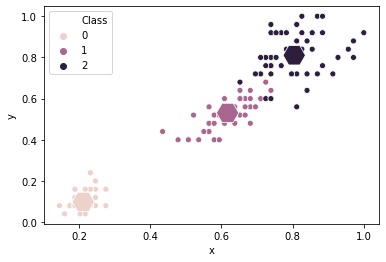

Quantization error =  0.08395154916225744
Davies-bouldin index score 1.627463668535614
            x         y  Class
0    0.645570  0.795455      0
1    0.620253  0.681818      0
2    0.594937  0.727273      0
3    0.582278  0.704545      0
4    0.632911  0.818182      0
..        ...       ...    ...
145  0.848101  0.681818      2
146  0.797468  0.568182      2
147  0.822785  0.681818      2
148  0.784810  0.772727      2
149  0.746835  0.681818      2

[150 rows x 3 columns]
0    50
Name: Class, dtype: int64
Cluster with class = 0  has an avg quantization error of  0.02620070097943487
1    50
Name: Class, dtype: int64
Cluster with class = 1  has an avg quantization error of  0.054404368831537875
2    50
Name: Class, dtype: int64
Cluster with class = 2  has an avg quantization error of  0.08499497796974353


<ipython-input-3-c4dfd83910aa>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_cluster['Centroid_distance'] = current_cluster[['x', 'y']].apply(lambda x: euclid_dist(x, centroid_list), axis=1)


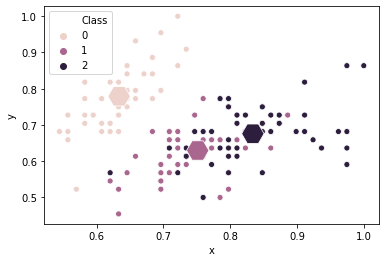

Quantization error =  0.08499497796974353
Davies-bouldin index score 1.627463668535614


In [7]:
iris_sklearn = datasets.load_iris()
iris_df = pd.DataFrame(data= np.c_[iris_sklearn['data'], iris_sklearn['target']],
                     columns= iris_sklearn['feature_names'] + ['target'])

# Petals
iris_df_pet = iris_df.loc[:, ["petal length (cm)", "petal width (cm)", "target"]]
iris_df_pet.rename(columns = {'petal length (cm)':'x', 'petal width (cm)':'y', 
                              'target':'Class'}, inplace = True) 
# iris_df_sep.loc[:,"x"] = iris_df_sep["x"].astype(float)
# iris_df_sep.loc[:,"y"] = iris_df_sep["y"].astype(float)
iris_df_pet.loc[:,"Class"] = iris_df_pet["Class"].astype(int)
iris_df_pet["x"] = iris_df_pet["x"]/iris_df_pet["x"].max()
iris_df_pet["y"] = iris_df_pet["y"]/iris_df_pet["y"].max()
print(iris_df_pet)
show_clustering(iris_df_pet, label="Class", clusters=3) # Ground truth

# Sepals
iris_df_sep = iris_df.loc[:, ["sepal length (cm)", "sepal width (cm)", "target"]]
iris_df_sep.rename(columns = {'sepal length (cm)':'x', 'sepal width (cm)':'y', 
                              'target':'Class'}, inplace = True) 
# iris_df_sep.loc[:,"x"] = iris_df_sep["x"].astype(float)
# iris_df_sep.loc[:,"y"] = iris_df_sep["y"].astype(float)
iris_df_sep.loc[:,"Class"] = iris_df_sep["Class"].astype(int)
iris_df_sep["x"] = iris_df_sep["x"]/iris_df_sep["x"].max()
iris_df_sep["y"] = iris_df_sep["y"]/iris_df_sep["y"].max()
print(iris_df_sep)
show_clustering(iris_df_sep, label="Class", clusters=3) # Ground truth

0    50
Name: Class, dtype: int64
Cluster with class = 0  has an avg quantization error of  0.01366017403188923
1    48
2     4
Name: Class, dtype: int64
Cluster with class = 1  has an avg quantization error of  0.04564510333673636
2    46
1     2
Name: Class, dtype: int64
Cluster with class = 2  has an avg quantization error of  0.08566132636762643


<ipython-input-3-c4dfd83910aa>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_cluster['Centroid_distance'] = current_cluster[['x', 'y']].apply(lambda x: euclid_dist(x, centroid_list), axis=1)


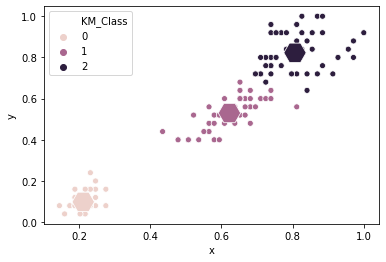

Quantization error =  0.08566132636762643
Davies-bouldin index score 1.1724712787084328


In [8]:
# Petals

kmeans = KMeans(n_clusters=3, random_state=0).fit(iris_df_pet[['x', 'y']])
iris_df_pet['KM_Class'] = kmeans.labels_
show_clustering(iris_df_pet, label="KM_Class", clusters=3)

0    49
Name: Class, dtype: int64
Cluster with class = 0  has an avg quantization error of  0.024985265308344315
1    36
2    20
0     1
Name: Class, dtype: int64
Cluster with class = 1  has an avg quantization error of  0.06189044996083485
2    30
1    14
Name: Class, dtype: int64
Cluster with class = 2  has an avg quantization error of  0.09474708720989455


<ipython-input-3-c4dfd83910aa>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_cluster['Centroid_distance'] = current_cluster[['x', 'y']].apply(lambda x: euclid_dist(x, centroid_list), axis=1)


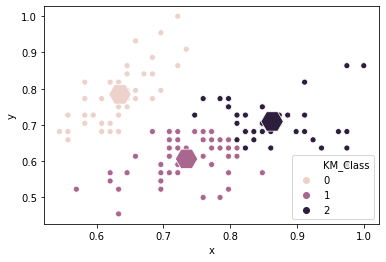

Quantization error =  0.09474708720989455
Davies-bouldin index score 1.1724712787084328


In [9]:
# Sepals

kmeans = KMeans(n_clusters=3, random_state=0).fit(iris_df_sep[['x', 'y']])
iris_df_sep['KM_Class'] = kmeans.labels_
show_clustering(iris_df_sep, label="KM_Class", clusters=3)

<ipython-input-5-437092e683ca>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  local_best.append(np.array([par, fitness]))


<ipython-input-5-437092e683ca>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  local_best[par_id] = np.array([par, fitness])


Iteration 10, Best Q-Error: 0.08069743331960468
Best particle centroids:
[[0.63965079 0.51812048]
 [0.21719911 0.08      ]
 [0.78326963 0.83590517]]


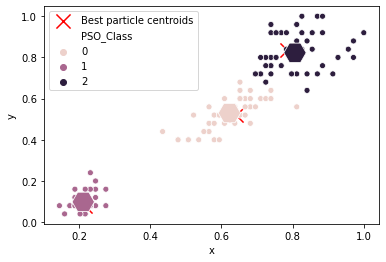

In [16]:
# Petals

num_clusters = 3
num_particles = 30
iterations = 10
part = []

means = PSO_clustering(iris_df_pet, iterations, num_clusters, num_particles)[0]
print("\nBest particle centroids:")
print(means)
labels = [np.argmin([euclid_dist([x,y], centroid) for centroid in means]) for (x, y) in zip(iris_df_pet['x'], iris_df_pet['y'])]
iris_df_pet['PSO_Class'] = labels
plt.scatter(means[:, 0], means[:, 1], marker = 'x', color = 'red', s = 200, label = 'Best particle centroids')
show_clustering(iris_df_pet, label="PSO_Class", clusters=len(set(labels)), compute_error = False)


<ipython-input-5-437092e683ca>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  local_best.append(np.array([par, fitness]))


<ipython-input-5-437092e683ca>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  local_best[par_id] = np.array([par, fitness])


Iteration 10, Best Q-Error: 0.06998405398724616
Best particle centroids:
[[0.71223312 0.5976771 ]
 [0.63148719 0.77932169]
 [0.81816059 0.68346066]]


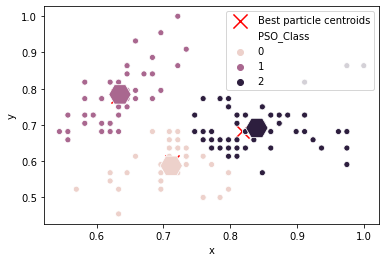

In [15]:
# Sepals

num_clusters = 3
num_particles = 30
iterations = 10

means = PSO_clustering(iris_df_sep, iterations, num_clusters, num_particles)[0]
print("\nBest particle centroids:")
print(means)
labels = [np.argmin([euclid_dist([x,y], centroid) for centroid in means]) for (x, y) in zip(iris_df_sep.x, iris_df_sep.y)]
iris_df_sep['PSO_Class'] = labels
plt.scatter(means[:, 0], means[:, 1], marker = 'x', color = 'red', s = 200, label = 'Best particle centroids')
show_clustering(iris_df_sep, label="PSO_Class", clusters=len(set(labels)), compute_error = False)